# Assignment 3

Erik Strand
3 November 2020

### Research Question

May is a busy month in Chicago, as the weather is starting to warm up and outdoor activities resume, yet school and work remain in session as well. However, in 2020, May was very different, as the COVID-19 pandemic was in nearly full effect. 

With this in mind, this analysis asks - how did rideshares in Chicago vary between May 2019 and May 2020? Were rideshares distributed equitably in May 2019, and did this trend improve, worsen, or stay the same in 2020? 

### Hypothesis

My initial hypothesis is that neighborhoods with higher concentrations of poor and Black residents will have lower access to rideshare services in general, and that this access will be even further decreased during the pandemic as compared to wealthier and whiter neighborhoods. 

In [25]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import geopandas as gpd
import contextily as ctx
from shapely.geometry import shape
import matplotlib.pyplot as plt
from urllib.parse import urlencode
import urllib.request, json
from plotnine import *
from statistics import mean

In [2]:
API = "https://data.cityofchicago.org/resource/m6dm-c72p.csv?"

# pulls rideshare data from May 2019, grouped by community area
query1 = {'$select': 'pickup_community_area, count(*) as total', 
          '$group': 'pickup_community_area',
        '$where': 'trip_start_timestamp>="2019-05-01" and trip_start_timestamp<="2019-06-01"', 
        '$limit': 5000000}

df = pd.read_csv(API + urlencode(query1))
print(len(df))
df.head()

78


,pickup_community_area,total
0,NaN,619317
1,21.0,100392
2,25.0,98942
3,67.0,32817
4,36.0,12148


In [4]:
# pulls rideshare data from May 2020, grouped by community area
query2 = {'$select': 'pickup_community_area, count(*) as total', 
          '$group': 'pickup_community_area',
        '$where': 'trip_start_timestamp>="2020-05-01" and trip_start_timestamp<="2020-06-01"', 
        '$limit': 5000000}

df2 = pd.read_csv(API + urlencode(query2))
print(len(df2))
df2.head()

78


,pickup_community_area,total
0,NaN,172663
1,21.0,21451
2,25.0,74244
3,67.0,24453
4,36.0,5367


In [91]:
tot_19_all = sum(df['total'])
tot_19_chi = sum(df.dropna()['total'])

tot_20_all = sum(df2['total'])
tot_20_chi = sum(df2.dropna()['total'])

print(tot_19_all)
print(tot_19_chi)
print(tot_20_all)
print(tot_20_chi)

print(tot_20_all - tot_19_all)
print(tot_20_chi - tot_19_chi)

print((tot_20_chi - tot_19_chi) / tot_19_chi)

9712194
9092877
1912452
1739789
-7799742
-7353088
-0.8086646283678972


In [5]:
rides19 = df.dropna()
rides20 = df2.dropna()

print(rides19.sort_values(by = 'total', ascending = False).head(10))
print(rides20.sort_values(by = 'total', ascending = False).head(10))

    pickup_community_area    total
5                     8.0  1589926
48                   32.0   890118
30                   28.0   808125
42                    6.0   651954
11                   24.0   580433
76                    7.0   510696
24                   76.0   373764
6                    22.0   340817
63                   33.0   227069
44                    3.0   196584
    pickup_community_area   total
6                     8.0  118063
30                   28.0   88830
42                    6.0   77363
2                    25.0   74244
11                   24.0   69430
48                   32.0   62161
26                   43.0   52419
76                    7.0   46238
5                    22.0   45798
44                    3.0   42693


epsg:4326
   area area_num_1 area_numbe  comarea  comarea_id        community  \
0   0.0         35         35      0.0         0.0          DOUGLAS   
1   0.0         36         36      0.0         0.0          OAKLAND   
2   0.0         37         37      0.0         0.0      FULLER PARK   
3   0.0         38         38      0.0         0.0  GRAND BOULEVARD   
4   0.0         39         39      0.0         0.0          KENWOOD   

   perimeter    shape_area     shape_len  \
0        0.0  4.600462e+07  31027.054510   
1        0.0  1.691396e+07  19565.506153   
2        0.0  1.991670e+07  25339.089750   
3        0.0  4.849250e+07  28196.837157   
4        0.0  2.907174e+07  23325.167906   

                                            geometry  
0  POLYGON ((1181573.250 1886828.039, 1181571.200...  
1  POLYGON ((1186289.356 1876750.733, 1186247.037...  
2  POLYGON ((1176344.998 1871187.546, 1176346.500...  
3  POLYGON ((1182322.043 1876674.730, 1182323.670...  
4  POLYGON ((1186289.35

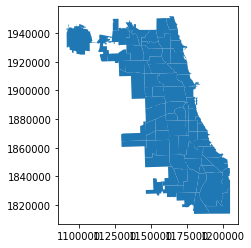

In [6]:
# read in shapefile with Chicago community area boundaries
comm_areas = gpd.read_file("../data/comm_area_shapefile")
print(comm_areas.crs)
comm_areas = comm_areas.to_crs(3435)
print(comm_areas.head())
print(comm_areas.crs)
comm_areas.plot()

In [7]:
# check column types for join
print(df.dtypes)
print(comm_areas.dtypes)

comm_areas["area_numbe"] = pd.to_numeric(comm_areas["area_numbe"], downcast='float')

print(df.dtypes)
print(comm_areas.dtypes)

pickup_community_area    float64
total                      int64
dtype: object
area           float64
area_num_1      object
area_numbe      object
comarea        float64
comarea_id     float64
community       object
perimeter      float64
shape_area     float64
shape_len      float64
geometry      geometry
dtype: object
pickup_community_area    float64
total                      int64
dtype: object
area           float64
area_num_1      object
area_numbe     float32
comarea        float64
comarea_id     float64
community       object
perimeter      float64
shape_area     float64
shape_len      float64
geometry      geometry
dtype: object


In [8]:
# join rideshare data to community area shapefiles 

rides_comms_19 = comm_areas.join(rides19.set_index('pickup_community_area'), on='area_numbe')
print(rides_comms_19.head())

rides_comms_20 = comm_areas.join(rides20.set_index('pickup_community_area'), on='area_numbe')
print(rides_comms_20.head())

   area area_num_1  area_numbe  comarea  comarea_id        community  \
0   0.0         35        35.0      0.0         0.0          DOUGLAS   
1   0.0         36        36.0      0.0         0.0          OAKLAND   
2   0.0         37        37.0      0.0         0.0      FULLER PARK   
3   0.0         38        38.0      0.0         0.0  GRAND BOULEVARD   
4   0.0         39        39.0      0.0         0.0          KENWOOD   

   perimeter    shape_area     shape_len  \
0        0.0  4.600462e+07  31027.054510   
1        0.0  1.691396e+07  19565.506153   
2        0.0  1.991670e+07  25339.089750   
3        0.0  4.849250e+07  28196.837157   
4        0.0  2.907174e+07  23325.167906   

                                            geometry  total  
0  POLYGON ((1181573.250 1886828.039, 1181571.200...  63652  
1  POLYGON ((1186289.356 1876750.733, 1186247.037...  12148  
2  POLYGON ((1176344.998 1871187.546, 1176346.500...   7606  
3  POLYGON ((1182322.043 1876674.730, 1182323.670...  

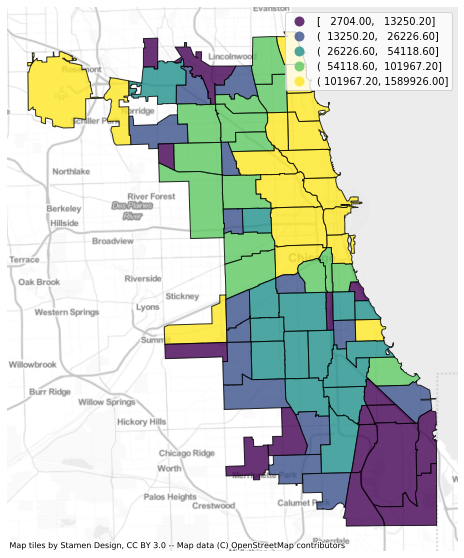

In [9]:
plot = rides_comms_19.plot(figsize = (10,10), column = 'total', scheme = 'quantiles', edgecolor = 'k', alpha = 0.8, legend = True)
ctx.add_basemap(ax = plot, source=ctx.providers.Stamen.TonerLite, crs='epsg:3435', alpha=0.5)

plt.axis(False)
plt.show()

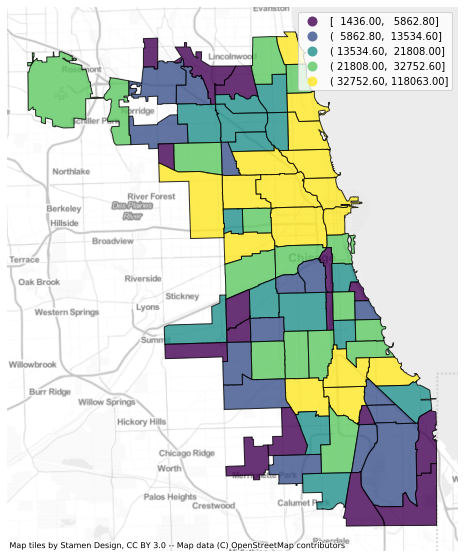

In [10]:
plot = rides_comms_20.plot(figsize = (10,10), column = 'total', scheme = 'quantiles', edgecolor = 'k', alpha = 0.8, legend = True)
ctx.add_basemap(ax = plot, source=ctx.providers.Stamen.TonerLite, crs='epsg:3435', alpha=0.5)

plt.axis(False)
plt.show()

In [11]:
rides_comms_20.head()

,area,area_num_1,area_numbe,comarea,comarea_id,community,perimeter,shape_area,shape_len,geometry,total
0,0.0,35,35.0,0.0,0.0,DOUGLAS,0.0,4.600462e+07,31027.054510,"POLYGON ((1181573.250 1886828.039, 1181571.200...",20111
1,0.0,36,36.0,0.0,0.0,OAKLAND,0.0,1.691396e+07,19565.506153,"POLYGON ((1186289.356 1876750.733, 1186247.037...",5367
2,0.0,37,37.0,0.0,0.0,FULLER PARK,0.0,1.991670e+07,25339.089750,"POLYGON ((1176344.998 1871187.546, 1176346.500...",3788
3,0.0,38,38.0,0.0,0.0,GRAND BOULEVARD,0.0,4.849250e+07,28196.837157,"POLYGON ((1182322.043 1876674.730, 1182323.670...",25391
4,0.0,39,39.0,0.0,0.0,KENWOOD,0.0,2.907174e+07,23325.167906,"POLYGON ((1186289.356 1876750.733, 1186290.775...",13309


In [74]:
rides_change = rides_comms_19.join(rides_comms_20[["total", "area_numbe"]].set_index('area_numbe'), on='area_numbe', lsuffix='_19', rsuffix='_20')
rides_change.head()

,area,area_num_1,area_numbe,comarea,comarea_id,community,perimeter,shape_area,shape_len,geometry,total_19,total_20
0,0.0,35,35.0,0.0,0.0,DOUGLAS,0.0,4.600462e+07,31027.054510,"POLYGON ((1181573.250 1886828.039, 1181571.200...",63652,20111
1,0.0,36,36.0,0.0,0.0,OAKLAND,0.0,1.691396e+07,19565.506153,"POLYGON ((1186289.356 1876750.733, 1186247.037...",12148,5367
2,0.0,37,37.0,0.0,0.0,FULLER PARK,0.0,1.991670e+07,25339.089750,"POLYGON ((1176344.998 1871187.546, 1176346.500...",7606,3788
3,0.0,38,38.0,0.0,0.0,GRAND BOULEVARD,0.0,4.849250e+07,28196.837157,"POLYGON ((1182322.043 1876674.730, 1182323.670...",53431,25391
4,0.0,39,39.0,0.0,0.0,KENWOOD,0.0,2.907174e+07,23325.167906,"POLYGON ((1186289.356 1876750.733, 1186290.775...",44043,13309


In [75]:
rides_change["change"] = rides_change['total_20'] - rides_change['total_19']
rides_change["perc_change"] = rides_change['change'] / rides_change['total_19'] * 100
rides_change.head()

,area,area_num_1,area_numbe,comarea,comarea_id,community,perimeter,shape_area,shape_len,geometry,total_19,total_20,change,perc_change
0,0.0,35,35.0,0.0,0.0,DOUGLAS,0.0,4.600462e+07,31027.054510,"POLYGON ((1181573.250 1886828.039, 1181571.200...",63652,20111,-43541,-68.404763
1,0.0,36,36.0,0.0,0.0,OAKLAND,0.0,1.691396e+07,19565.506153,"POLYGON ((1186289.356 1876750.733, 1186247.037...",12148,5367,-6781,-55.819888
2,0.0,37,37.0,0.0,0.0,FULLER PARK,0.0,1.991670e+07,25339.089750,"POLYGON ((1176344.998 1871187.546, 1176346.500...",7606,3788,-3818,-50.197213
3,0.0,38,38.0,0.0,0.0,GRAND BOULEVARD,0.0,4.849250e+07,28196.837157,"POLYGON ((1182322.043 1876674.730, 1182323.670...",53431,25391,-28040,-52.478898
4,0.0,39,39.0,0.0,0.0,KENWOOD,0.0,2.907174e+07,23325.167906,"POLYGON ((1186289.356 1876750.733, 1186290.775...",44043,13309,-30734,-69.781804


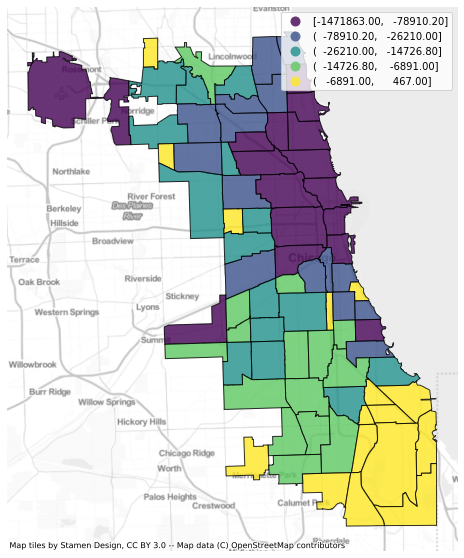

In [14]:
plot = rides_change.plot(figsize = (10,10), column = 'change', scheme = 'quantiles', edgecolor = 'k', alpha = 0.8, legend = 'reverse')
ctx.add_basemap(ax = plot, source=ctx.providers.Stamen.TonerLite, crs='epsg:3435', alpha=0.5)
plt.axis(False)
plt.show()

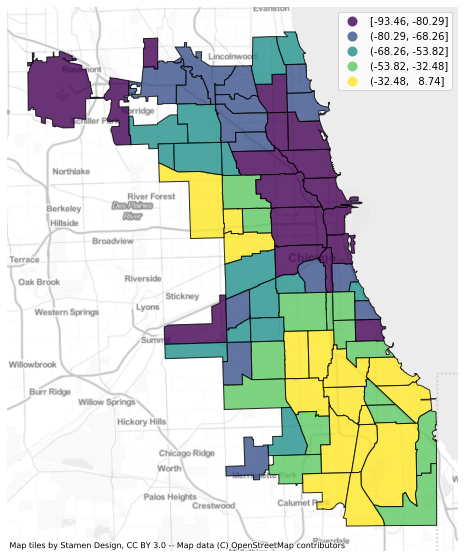

In [15]:
plot = rides_change.plot(figsize = (10,10), column = 'perc_change', scheme = 'quantiles', edgecolor = 'k', alpha = 0.8, legend = 'reverse')
ctx.add_basemap(ax = plot, source=ctx.providers.Stamen.TonerLite, crs='epsg:3435', alpha=0.5)
plt.axis(False)
plt.show()

In [19]:
# read shapefile of Chicago community areas with basic demographic info
chi_comms_demo = gpd.read_file("../data/chi_comms_demographics")
chi_comms_demo.crs
chi_comms_demo = chi_comms_demo.to_crs(3435)

chi_comms_demo.head()

,are_nmb,white,black,nt_hspn,hispanc,pv__100,p_100_1,pv_150_,geometry
0,1,57161.0,21749.0,78848.0,19191.0,20626.0,9837.0,62319.0,"POLYGON ((1168756.115 1942653.009, 1168435.059..."
1,10,83573.0,1182.0,83683.0,12453.0,7397.0,5932.0,81579.0,"POLYGON ((1134653.334 1942133.392, 1134525.530..."
2,11,69680.0,1141.0,67140.0,19833.0,7511.0,5286.0,73878.0,"POLYGON ((1142170.617 1931452.395, 1142128.720..."
3,12,57809.0,1314.0,63671.0,13753.0,6134.0,4894.0,65217.0,"POLYGON ((1137581.157 1944876.759, 1137581.157..."
4,13,41418.0,2551.0,51185.0,13138.0,7554.0,5642.0,49760.0,"POLYGON ((1154567.544 1937047.257, 1154572.380..."


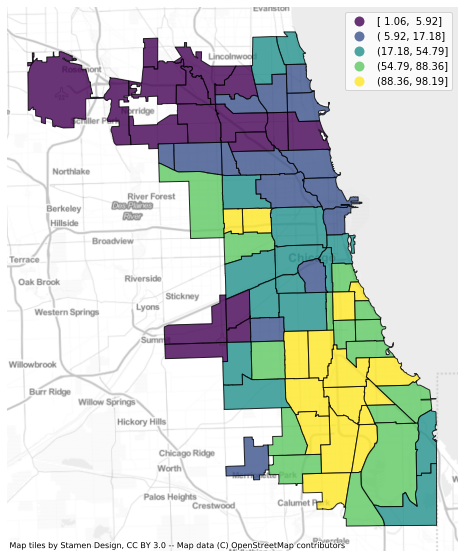

In [23]:
chi_comms_demo["perc_black"] = (chi_comms_demo["black"] / (chi_comms_demo["black"] + chi_comms_demo["white"])) * 100

plot = chi_comms_demo.plot(figsize = (10,10), column = 'perc_black', scheme = 'quantiles', edgecolor = 'k', alpha = 0.8, legend = 'reverse')
ctx.add_basemap(ax = plot, source=ctx.providers.Stamen.TonerLite, crs='epsg:3435', alpha=0.5)
plt.axis(False)
plt.show()

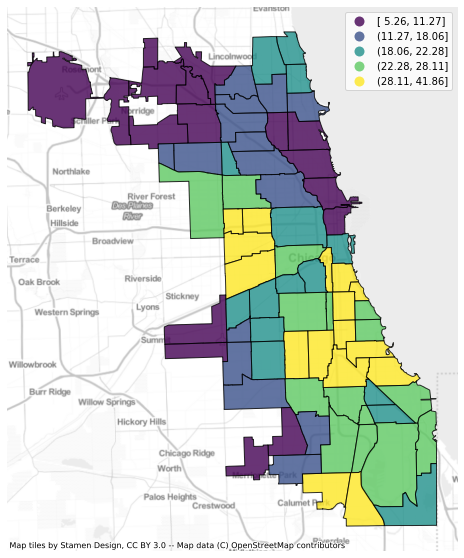

In [24]:
chi_comms_demo["perc_poor"] = (chi_comms_demo["pv__100"] / (chi_comms_demo["pv__100"] + chi_comms_demo["p_100_1"] + chi_comms_demo["pv_150_"])) * 100

plot = chi_comms_demo.plot(figsize = (10,10), column = 'perc_poor', scheme = 'quantiles', edgecolor = 'k', alpha = 0.8, legend = 'reverse')
ctx.add_basemap(ax = plot, source=ctx.providers.Stamen.TonerLite, crs='epsg:3435', alpha=0.5)
plt.axis(False)
plt.show()

In [77]:
chi_comms_demo["are_nmb"] = pd.to_numeric(chi_comms_demo["are_nmb"], downcast='float')
rides_change_df = pd.DataFrame(rides_change)
rides_change_df = rides_change.drop(columns=['geometry'])
rides_demographics = chi_comms_demo.join(rides_change_df.set_index('area_numbe'), on="are_nmb")

print(rides_demographics.columns.to_list())
rides_demographics.head()

['are_nmb', 'white', 'black', 'nt_hspn', 'hispanc', 'pv__100', 'p_100_1', 'pv_150_', 'geometry', 'perc_black', 'perc_poor', 'area_numbe', 'area', 'area_num_1', 'comarea', 'comarea_id', 'community', 'perimeter', 'shape_area', 'shape_len', 'total_19', 'total_20', 'change', 'perc_change']


,are_nmb,white,black,nt_hspn,hispanc,pv__100,p_100_1,pv_150_,geometry,perc_black,...,comarea,comarea_id,community,perimeter,shape_area,shape_len,total_19,total_20,change,perc_change
0,1.0,57161.0,21749.0,78848.0,19191.0,20626.0,9837.0,62319.0,"POLYGON ((1168756.115 1942653.009, 1168435.059...",27.561779,...,0.0,0.0,ROGERS PARK,0.0,5.125990e+07,34052.397576,102361,32824,-69537,-67.933100
1,10.0,83573.0,1182.0,83683.0,12453.0,7397.0,5932.0,81579.0,"POLYGON ((1134653.334 1942133.392, 1134525.530...",1.394608,...,0.0,0.0,NORWOOD PARK,0.0,1.219591e+08,80368.374378,28953,6078,-22875,-79.007357
2,11.0,69680.0,1141.0,67140.0,19833.0,7511.0,5286.0,73878.0,"POLYGON ((1142170.617 1931452.395, 1142128.720...",1.611104,...,0.0,0.0,JEFFERSON PARK,0.0,6.486816e+07,44011.957170,25086,6408,-18678,-74.455872
3,12.0,57809.0,1314.0,63671.0,13753.0,6134.0,4894.0,65217.0,"POLYGON ((1137581.157 1944876.759, 1137581.157...",2.222485,...,0.0,0.0,FOREST GLEN,0.0,8.913089e+07,74493.821604,12459,2491,-9968,-80.006421
4,13.0,41418.0,2551.0,51185.0,13138.0,7554.0,5642.0,49760.0,"POLYGON ((1154567.544 1937047.257, 1154572.380...",5.801815,...,0.0,0.0,NORTH PARK,0.0,7.028871e+07,41581.948654,21079,5379,-15700,-74.481712


In [83]:
# create linear model for relationship between % Black pop and % change in rides from 2019 to 2020

x = rides_demographics["perc_change"].values
y = rides_demographics["black"].values.reshape((-1,1))

model1 = LinearRegression().fit(y, x)

print('slope = ', model1.coef_)

slope =  [0.000735]


In [82]:
# create linear model for relationship between % poverty and % change in rides from 2019 to 2020

x = rides_demographics["perc_change"].values
y = rides_demographics["pv__100"].values.reshape((-1,1))

model2 = LinearRegression().fit(y, x)

print('slope = ', model2.coef_)

slope =  [0.00102555]


In [78]:
rides_demographics["per_cap_rides_19"] = rides_demographics["total_19"] / (rides_demographics["white"] + rides_demographics["black"])
rides_demographics["per_cap_rides_20"] = rides_demographics["total_20"] / (rides_demographics["white"] + rides_demographics["black"])

rides_demographics.head()

,are_nmb,white,black,nt_hspn,hispanc,pv__100,p_100_1,pv_150_,geometry,perc_black,...,community,perimeter,shape_area,shape_len,total_19,total_20,change,perc_change,per_cap_rides_19,per_cap_rides_20
0,1.0,57161.0,21749.0,78848.0,19191.0,20626.0,9837.0,62319.0,"POLYGON ((1168756.115 1942653.009, 1168435.059...",27.561779,...,ROGERS PARK,0.0,5.125990e+07,34052.397576,102361,32824,-69537,-67.933100,1.297187,0.415968
1,10.0,83573.0,1182.0,83683.0,12453.0,7397.0,5932.0,81579.0,"POLYGON ((1134653.334 1942133.392, 1134525.530...",1.394608,...,NORWOOD PARK,0.0,1.219591e+08,80368.374378,28953,6078,-22875,-79.007357,0.341608,0.071713
2,11.0,69680.0,1141.0,67140.0,19833.0,7511.0,5286.0,73878.0,"POLYGON ((1142170.617 1931452.395, 1142128.720...",1.611104,...,JEFFERSON PARK,0.0,6.486816e+07,44011.957170,25086,6408,-18678,-74.455872,0.354217,0.090482
3,12.0,57809.0,1314.0,63671.0,13753.0,6134.0,4894.0,65217.0,"POLYGON ((1137581.157 1944876.759, 1137581.157...",2.222485,...,FOREST GLEN,0.0,8.913089e+07,74493.821604,12459,2491,-9968,-80.006421,0.210730,0.042133
4,13.0,41418.0,2551.0,51185.0,13138.0,7554.0,5642.0,49760.0,"POLYGON ((1154567.544 1937047.257, 1154572.380...",5.801815,...,NORTH PARK,0.0,7.028871e+07,41581.948654,21079,5379,-15700,-74.481712,0.479406,0.122336


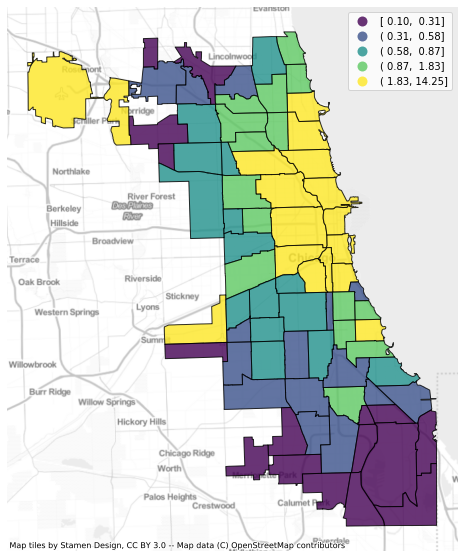

In [79]:
plot = rides_demographics.plot(figsize = (10,10), column = 'per_cap_rides_19', scheme = 'quantiles', edgecolor = 'k', alpha = 0.8, legend = 'reverse')
ctx.add_basemap(ax = plot, source=ctx.providers.Stamen.TonerLite, crs='epsg:3435', alpha=0.5)
plt.axis(False)
plt.show()

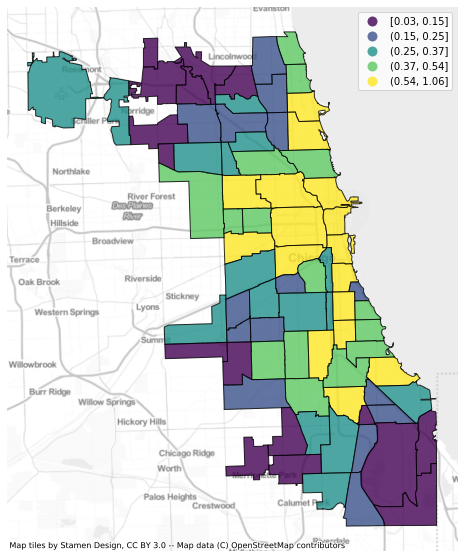

In [80]:
plot = rides_demographics.plot(figsize = (10,10), column = 'per_cap_rides_20', scheme = 'quantiles', edgecolor = 'k', alpha = 0.8, legend = 'reverse')
ctx.add_basemap(ax = plot, source=ctx.providers.Stamen.TonerLite, crs='epsg:3435', alpha=0.5)
plt.axis(False)
plt.show()

In [84]:
# create linear model for relationship between % Black pop and rides per cap in 2019

x = rides_demographics["per_cap_rides_19"].values
y = rides_demographics["perc_black"].values.reshape((-1,1))

model3 = LinearRegression().fit(y, x)

print('slope = ', model3.coef_)

slope =  [-0.01636333]


In [92]:
# create linear model for relationship between % Black pop and rides per cap in 2019

x = rides_demographics["total_19"].values
y = rides_demographics["black"].values.reshape((-1,1))

model35 = LinearRegression().fit(y, x)

print('slope = ', model35.coef_)

slope =  [-1.45355559]


In [85]:
# create linear model for relationship between % Black pop and rides per cap in 2020

x = rides_demographics["per_cap_rides_20"].values
y = rides_demographics["perc_black"].values.reshape((-1,1))

model4 = LinearRegression().fit(y, x)

print('slope = ', model4.coef_)

slope =  [0.00150376]
